In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\38066\AppData\Local\Temp\tmpg24mykqf
  JVM stdout: C:\Users\38066\AppData\Local\Temp\tmpg24mykqf\h2o_38066_started_from_python.out
  JVM stderr: C:\Users\38066\AppData\Local\Temp\tmpg24mykqf\h2o_38066_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_38066_uyf5vm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.952 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [67]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_01.02_v2.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = []
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features or "angle" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

X = X.fillna(0)
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(X)
poly_column_names = poly.get_feature_names_out(X.columns)
X = pd.DataFrame(X_poly, columns=poly_column_names, index=X.index)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['avg_atoms_in_cycle', 'nFaHRing', 'chirality', 'PPSA5', 'tpsa+f', 'RPCS', 'mol_num_cycles', 'GeomShapeIndex', 'angle_R2X2R1', 'nN', 'distance_between_atoms_in_f_group_centers', 'nC', 'nFARing', 'angle_R1X1R2', 'f_freedom', 'naHRing', 'nFAHRing', 'cis/trans', 'dipole_moment', 'f_to_fg', 'identificator', 'f_atom_fraction', 'nFRing', 'nFaRing', 'naRing', 'nFHRing', 'PBF', 'nARing', 'nF', 'dihedral_angle', 'nAHRing', 'nO', 'TASA', 'angle_X2X1R1', 'mol_volume', 'FPSA3', 'PNSA5', 'angle_X1X2R2', 'nHRing', 'pKa', 'logP']
distance_between_atoms_in_f_group_centers [35]
dipole_moment [82]
f_atom_fraction [124]
PBF [40, 71, 127]
mol_volume [127]
FPSA3 [40]
PNSA5 [37, 38]
logP [82, 83]
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182],
      dtype='int64', length=183)
Remains rows:105, amount of features: 41
92 13
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse 

In [53]:
x = train.columns
# x.remove('C1')
y = "pKa"
x.remove(y)

# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, leaderboard_frame=test, fold_column="fold_id")

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |
19:23:53.967: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
19:23:53.981: AutoML: XGBoost is not available; skipping it.
19:23:54.40: _train param, Dropping bad and constant columns: [nFRing naRing, naRing nFHRing, naRing TASA, naRing mol_volume, f_to_fg naRing, naRing PBF, GeomShapeIndex naRing, f_freedom naRing, naRing nAHRing, naRing PNSA5, distance_between_atoms_in_f_group_centers naRing, naRing nARing, nFARing naRing, chirality naRing, PPSA5 naRing, cis/trans nFHRing, chirality nFHRing, mol_num_cycles naRing, RPCS naRing, naRing FPSA3, nFAHRing cis/trans, naRing nHRing, 1, naRing, dipole_moment naRing, avg_atoms_in_cycle naRing, nFAHRing naRing, cis/trans naRing, naRing nF, identificator naRing, chirality nFAHRing, naRing nO, nN naRing, nC naRing]


19:23:55.223: _train param, Dropping bad and constant columns: [nFRing naRing, naRing nFHRing, naRing TASA, naRing mol_volume, f_to_fg naRing, naRing PBF, GeomShapeIndex naR

In [18]:
best_prev_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\25.01.24_features\pKa\Only_mol_with_angles_without_outliers(except_dipole)_with_angles(as features)\DeepLearning_grid_3_AutoML_1_20240126_235839_model_3')

top_features = []
for feature_index in range(15):
    top_features.append(best_prev_model.varimp()[feature_index][0])
top_features

unimportant_features_to_drop = []
for feature_name in X.columns:
    if feature_name not in top_features:
        unimportant_features_to_drop.append(feature_name)

unimportant_features_to_drop

['dipole_moment',
 'nHRing',
 'avg_atoms_in_cycle',
 'angle_R2X2R1',
 'nF',
 'nFRing',
 'f_freedom',
 'mol_num_cycles',
 'nFAHRing',
 'distance_between_atoms_in_f_group_centers',
 'nC',
 'nAHRing',
 'mol_volume',
 'nFaRing',
 'nFHRing',
 'angle_X2X1R1',
 'nFaHRing',
 'RPCS',
 'naRing',
 'nFARing',
 'naHRing',
 'chirality',
 'nARing']

TEST metrics:

In [68]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.286, 'mae': 0.378, 'r^2': 0.945}

TRAIN metrics

In [62]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.28, 'mae': 0.363, 'r^2': 0.957}

In [55]:
best_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
Metalearner algorithm,GBM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,fold_id


In [19]:
best_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\pKa\all_molecules(without_angle_feature)_without_outliers\DeepLearning_grid_1_AutoML_3_20240201_153554_model_72')

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.11, 'mae': 0.285, 'r^2': 0.979}

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_10780\2639209905.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])


Text(0.5, 0, 'H2O Feature Importance')

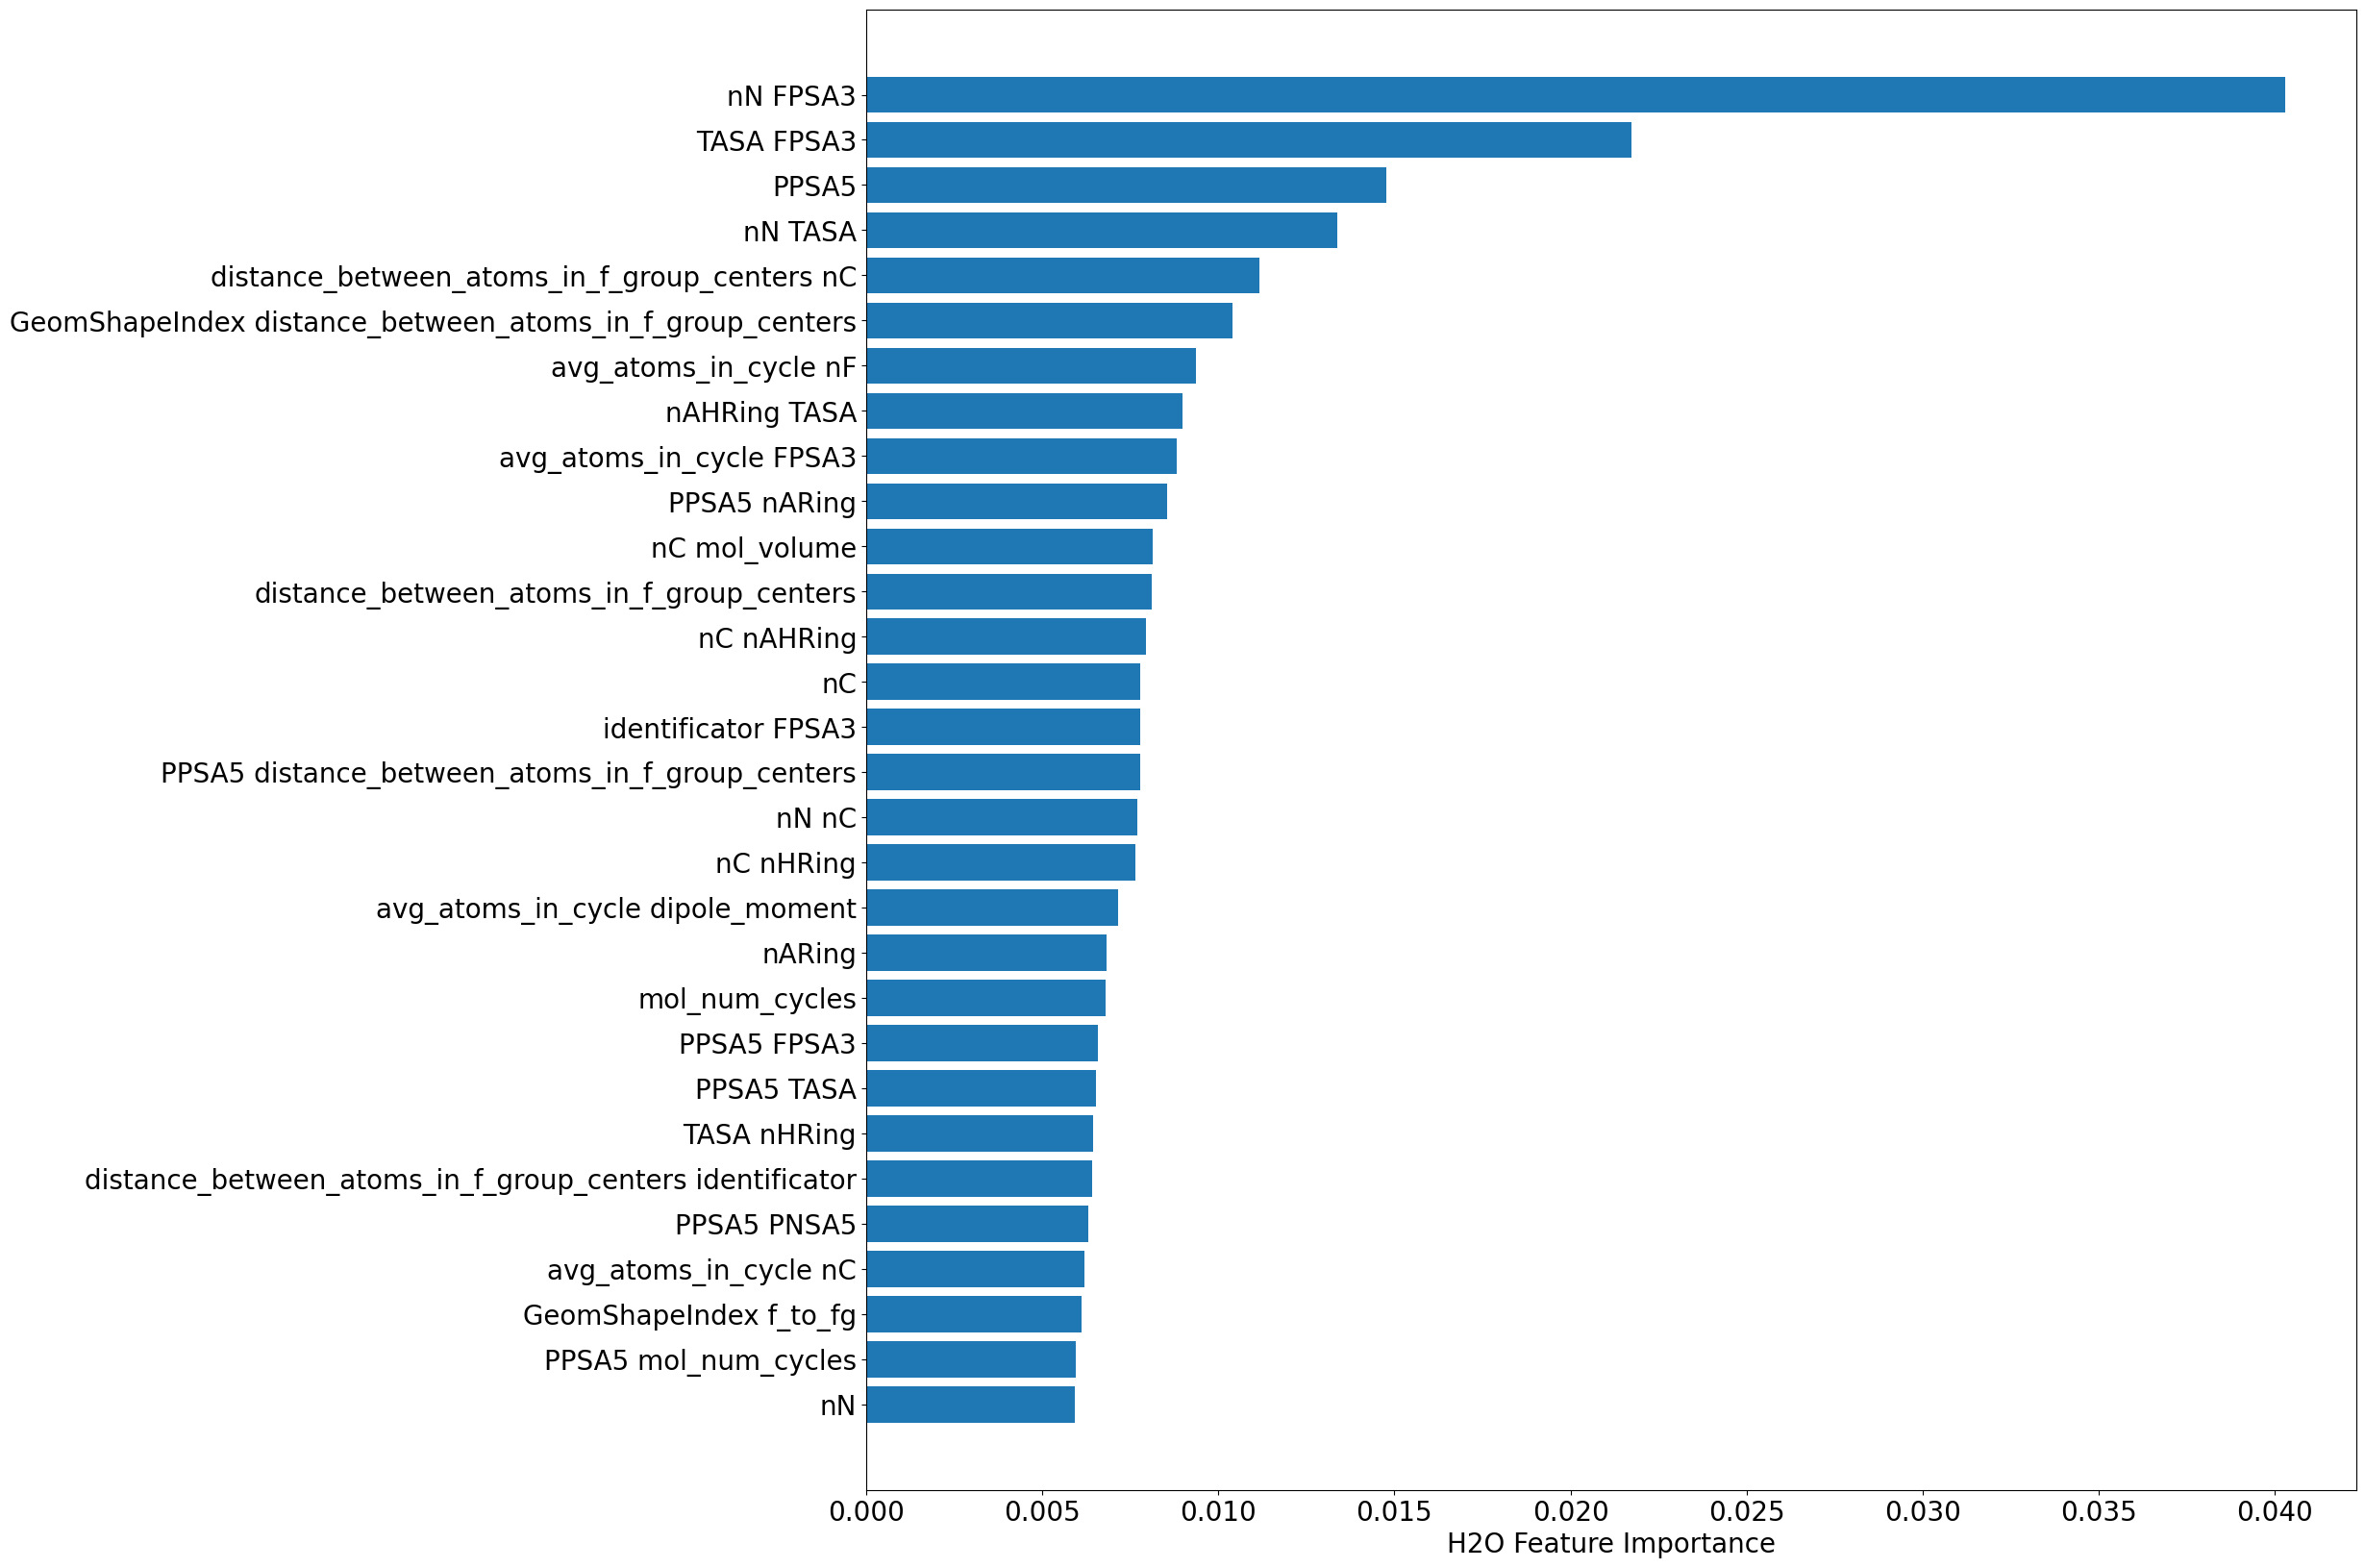

In [59]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=100)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

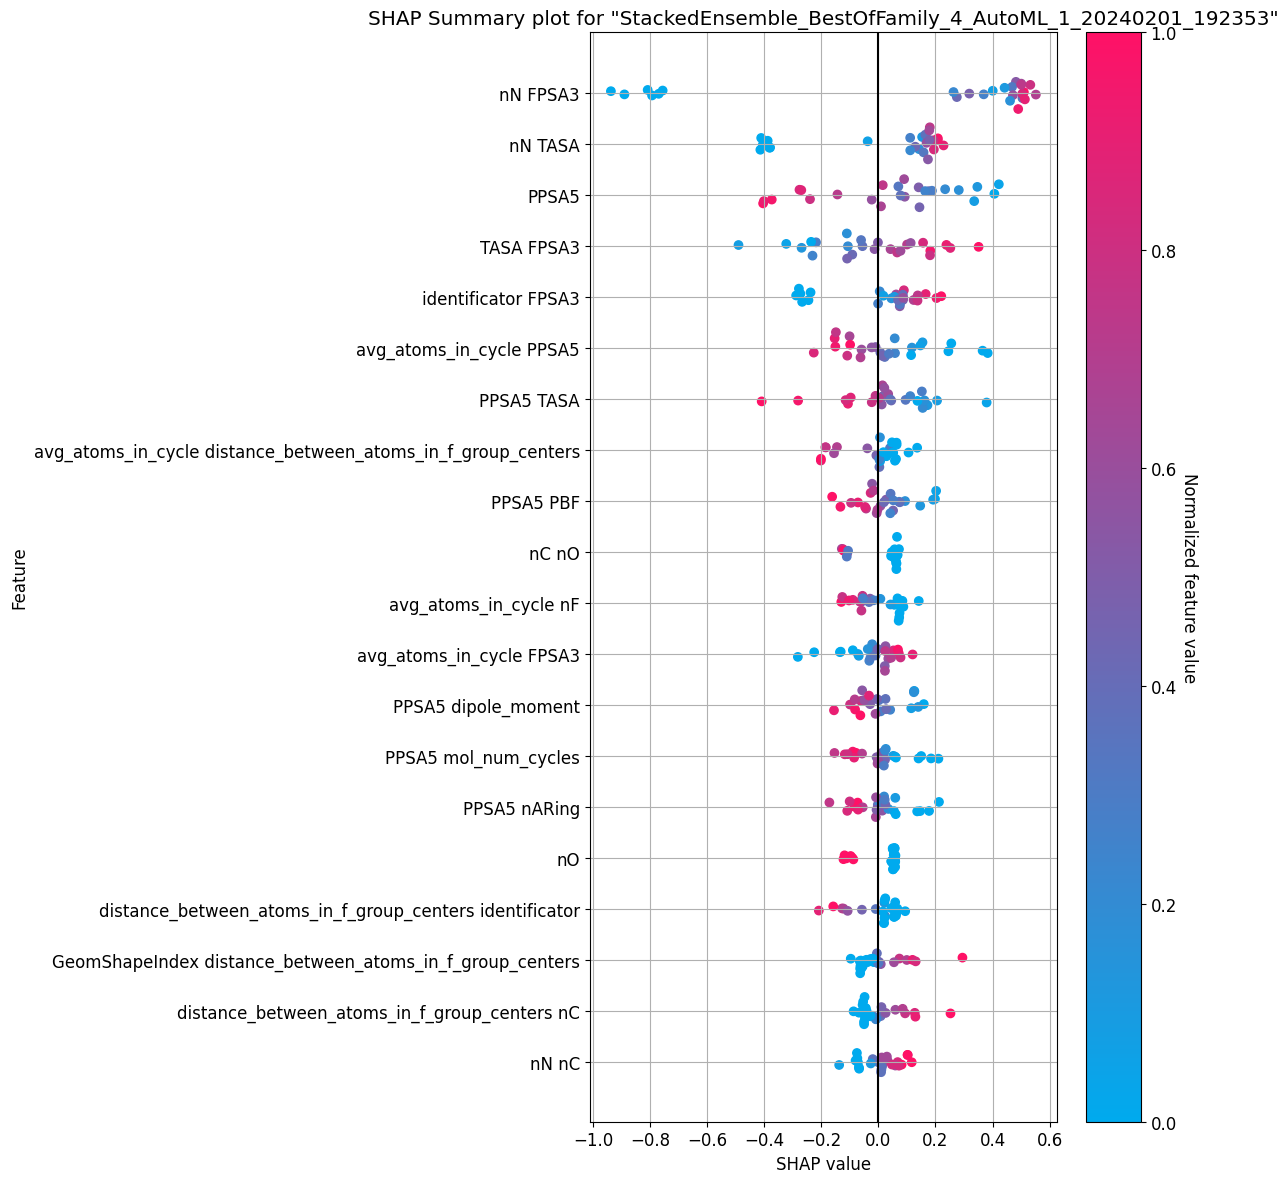

In [65]:
plt.rcParams.update({"font.size": 12})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=2000)

VAR IMPORTANCE

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


TypeError: 'NoneType' object is not subscriptable

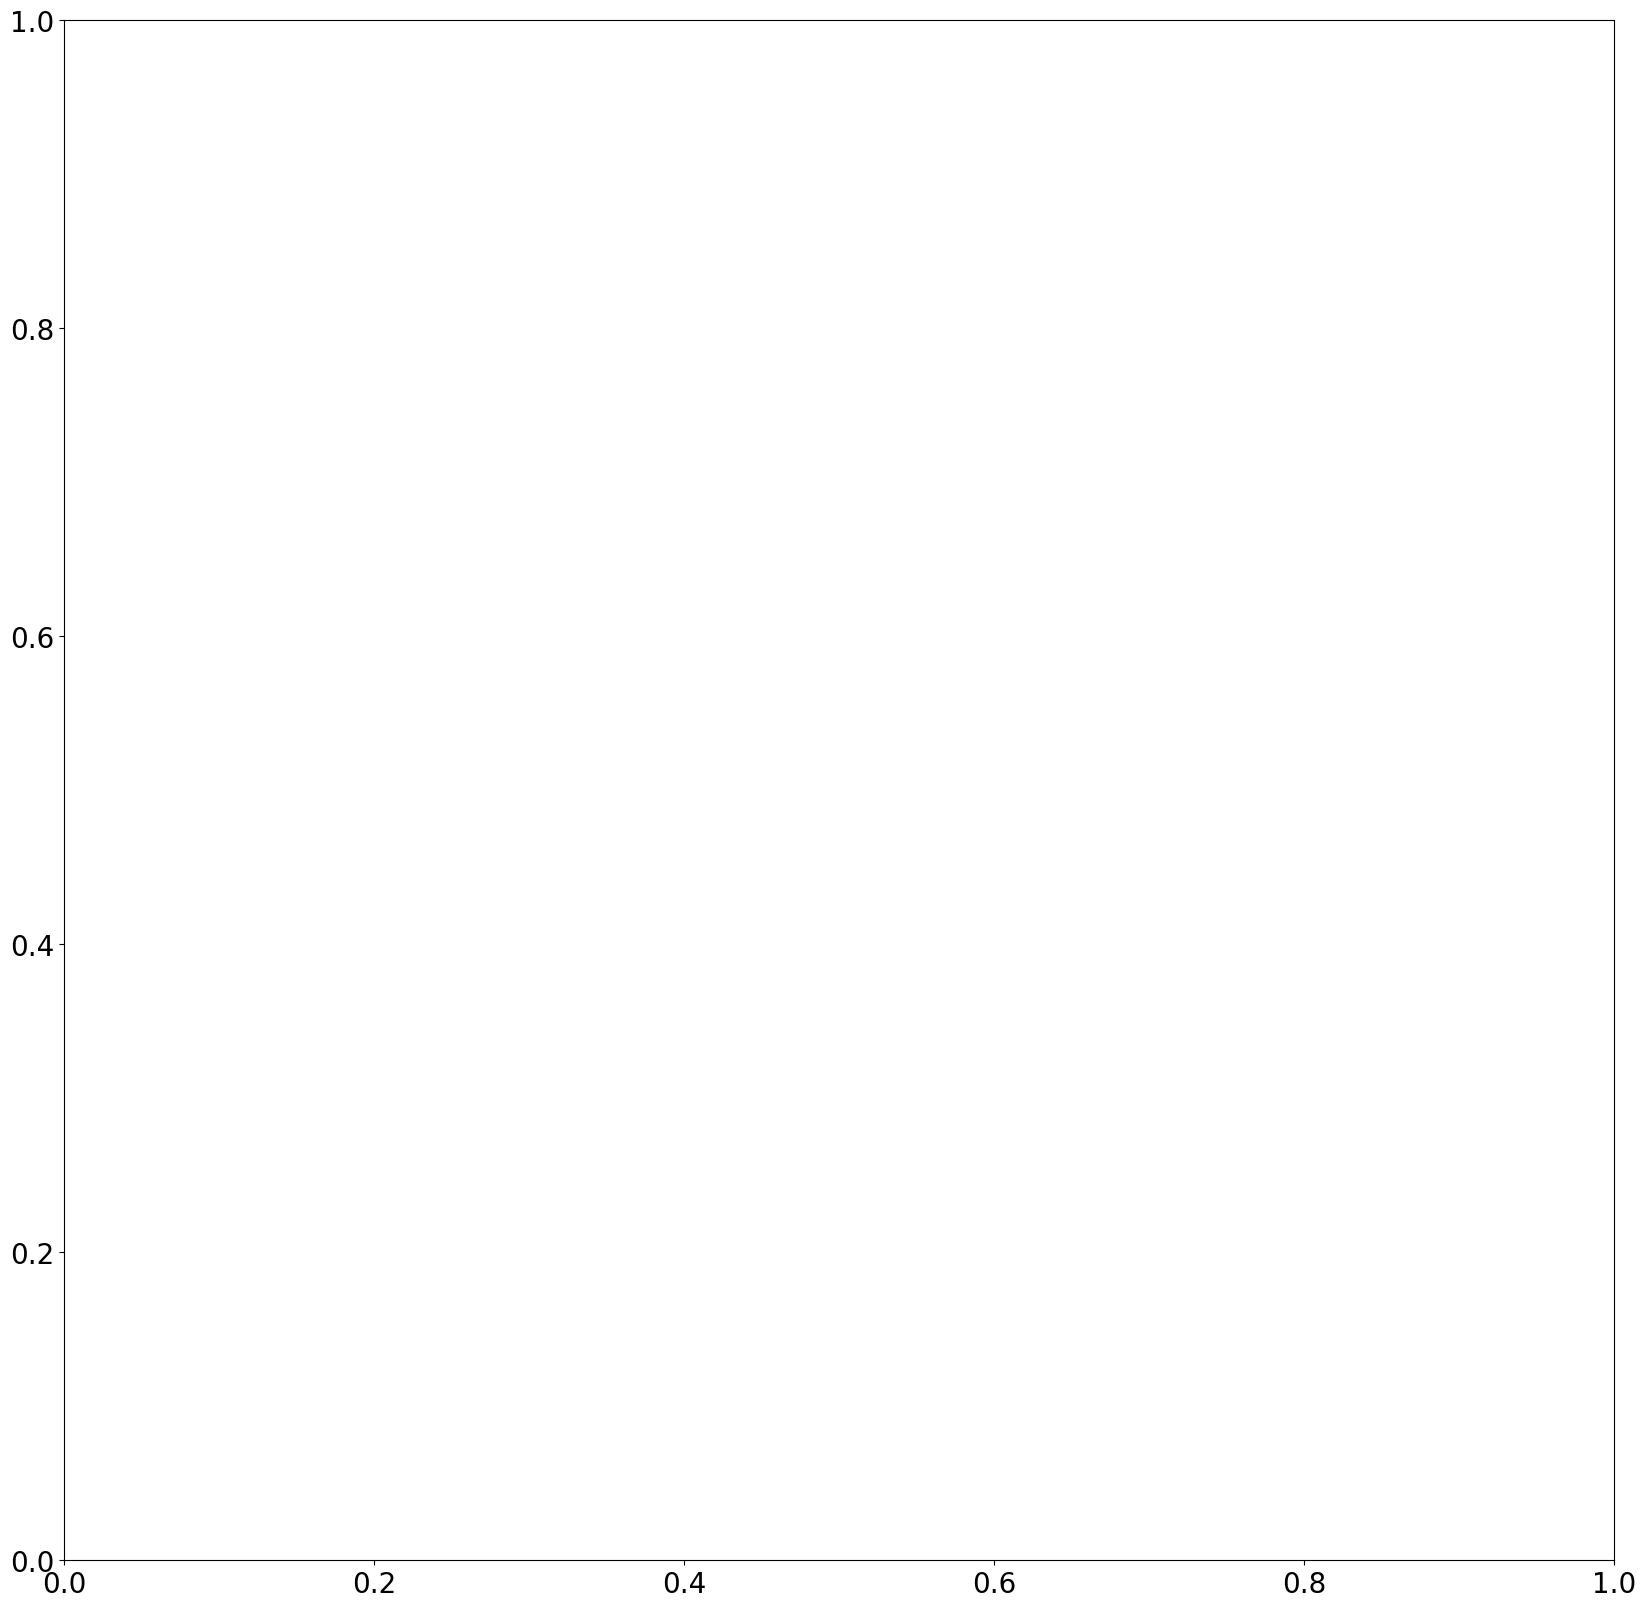

In [64]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = best_model.varimp(test)

fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
ax.set_xlabel('Percent')


BEST MODEL SAVING

In [66]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'all_molecules_using_PolynomialFeatures(without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\01.02.24_features_2.1\\pKa\\all_molecules_using_PolynomialFeatures(without_angle_feature)_without_outliers\\StackedEnsemble_BestOfFamily_4_AutoML_1_20240201_192353'